In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [1]:
import os
import numpy as np
import pickle
import keras
import tensorflow as tf
import warnings
from matplotlib import pyplot as plt
from IPython.display import clear_output

from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten, LSTM, Embedding, Activation, Add
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.regularizers import l2 # L2-regularisation
from keras.models import Model
from keras import optimizers
from keras.layers.advanced_activations import LeakyReLU

warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [14]:
def load_data(data_name):
    pkl_file = open(data_name + '.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

print('Loading data...')
folder = '../input/aminodataset/'

train = np.array(load_data(folder + 'train'))
train_label = load_data(folder + 'train_label')
test = np.array(load_data(folder + 'test'))
test_label = load_data(folder + 'test_label')
valid = np.array(load_data(folder + 'valid'))
valid_label = load_data(folder + 'valid_label')
print('Data are loaded')

Loading data...
Data are loaded


In [ ]:
print(cnt)

In [15]:
train = train.reshape(train.shape[0], train.shape[1], train.shape[2])
test = test.reshape(test.shape[0], test.shape[1], test.shape[2])
valid = valid.reshape(valid.shape[0], valid.shape[1], valid.shape[2])

In [ ]:
train.shape, np.shape(train_label)

### LSTM

In [27]:
def lstm(input_shape, output_shape, mm):
    
    l2_lambda = 0.0001
    
    inputs = Input(input_shape)
    
    layer = (LSTM(16, return_sequences=True))(inputs)
    layer = (Dropout(0.5))(layer)
    
    layer = (LSTM(32, return_sequences=True))(inputs)
    layer = (Dropout(0.5))(layer)
    
    layer = (LSTM(64))(layer)
    layer = (Dropout(0.5))(layer)
        
#     output = (Dense(128, activation = 'linear', W_regularizer = l2(l2_lambda)))(layer) 
#     output = (ReLU())(layer)
#     output = (Dropout(0.3))(output)
    
#     output = (Dense(2, activation = 'softmax', name = 'main_output' + str(i)))(output)

    finish = []
#     output = (Dense(2, activation = 'softmax', name = 'main_output'))(layer)
    for i in range(int((mm ** 2 - mm ) / 2)):
        output = (Dense(2, activation = 'softmax', name = 'main_output' + str(i)))(layer)
        finish.append(output)

    model = Model(inputs = [inputs], outputs = finish)
    
    model.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy'
    )
    
    return model

In [ ]:
no_diag = int((mm ** 2 - mm) / 2) - (2 * mm - 3)
no_main = int((mm ** 2 - mm) / 2)

In [17]:
batch_size = 32
epochs = 30
mm = 40

model = lstm((train.shape[1], train.shape[2]), 2, mm)

class_weight = {0: 1.,
                1: 5.}

print('Start training...')
history = model.fit(train, list(train_label), batch_size = batch_size, epochs = epochs, verbose = 0,
                          validation_data=(valid, list(valid_label)))

Start training...


In [26]:
predicted = model.predict(test)

print(np.shape(predicted))
print(np.shape(test_label))

output = open('predicted_l' + '.pkl', 'wb')
pickle.dump(predicted, output)
output.close()

output = open('test_l' + '.pkl', 'wb')
pickle.dump(test_label, output)
output.close()

(780, 73, 2)
(780, 73, 2)


In [ ]:
np.shape(predicted)

In [12]:
predicted = np.array(predicted).reshape(780 * 73, 2)
test_label = np.array(test_label).reshape(780 * 73, 2)

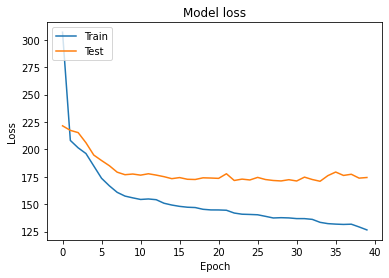

In [18]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('bilstm')

In [23]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import operator
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


def score(test_label, predicted, metric):
    
    predicted = np.array(predicted).reshape(780 * 73, 2)
    test_label = np.array(test_label).reshape(780 * 73, 2)
    
    id_score = {}
    pred = []
    test = []
    
    L = []
    L_2 = []
    L_5 = []
    L_10 = []
    
    for i in range(len(predicted)):
        id_score[i] = predicted[i][1]
        
    for key, value in reversed(sorted(id_score.items(), key=operator.itemgetter(1))):
        pred.append(np.argmax([1 - value, value]))
        test.append(np.argmax(test_label[key]))
        
    if metric == 'recall':
        
        L.append(recall_score(test, pred))
        L_2.append(recall_score(test[:len(test) // 2], pred[:len(pred) // 2]))
        L_5.append(recall_score(test[:len(test) // 5], pred[:len(pred) // 5]))
        L_10.append(recall_score(test[:len(test) // 10], pred[:len(pred) // 10]))
        
    elif metric == 'f1':
        
        L.append(f1_score(test, pred))
        L_2.append(f1_score(test[:len(test) // 2], pred[:len(pred) // 2]))
        L_5.append(f1_score(test[:len(test) // 5], pred[:len(pred) // 5]))
        L_10.append(f1_score(test[:len(test) // 10], pred[:len(pred) // 10]))
        
    elif metric == 'precision':
        
        L.append(precision_score(test, pred))
        L_2.append(precision_score(test[:len(test) // 2], pred[:len(pred) // 2]))
        L_5.append(precision_score(test[:len(test) // 5], pred[:len(pred) // 5]))
        L_10.append(precision_score(test[:len(test) // 10], pred[:len(pred) // 10]))
        
    else:
        
        raise ValueError('No metric was found')
            
    return L, L_2, L_5, L_10

In [24]:
def print_results(test_label, proba):
    
    # f1 score
    
    L, L_2, L_5, L_10 = score(test_label, proba, 'f1')
    print('F1 score:')
    print('L:', L)
    print('L_2:', L_2)
    print('L_5:', L_5)
    print('L_10:', L_10)
    
    # precision score
    
    L, L_2, L_5, L_10 = score(test_label, proba, 'precision')
    print('Precision score:')
    print('L:', L)
    print('L_2:', L_2)
    print('L_5:', L_5)
    print('L_10:', L_10)
    
    
    # recall score
    
    L, L_2, L_5, L_10 = score(test_label, proba, 'recall')
    print('Recall score:')
    print('L:', L)
    print('L_2:', L_2)
    print('L_5:', L_5)
    print('L_10:', L_10)

In [25]:
print_results(test_label, predicted)

F1 score:
L: [0.7717293233082705]
L_2: [0.7793233311061167]
L_5: [0.8551053052519328]
L_10: [0.9803921568627451]
Precision score:
L: [0.8790079473828446]
L_2: [0.8790079473828446]
L_5: [0.8790079473828446]
L_10: [0.9615384615384616]
Recall score:
L: [0.6877881419534684]
L_2: [0.6999454446262957]
L_5: [0.8324682065922657]
L_10: [1.0]


In [ ]:
from keras.utils import plot_model
from IPython.display import Image
from matplotlib.pyplot import savefig

model = bilstm((train.shape[1], train.shape[2]), 2, mm)

plot_model(model, show_shapes=True, show_layer_names=True, to_file='lstm_arch.png')

# Image(retina=True, filename='model2.png')